In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
df=pd.read_csv("NYC_obgyn_final.csv", header=None)
df.columns=["Malpractice","Boro","Education","Name","Specialty"]

In [3]:
def split_out_year(ed):
    try:
        s=re.search(',\n',ed).span()
    except:
        s=(None,None)
    school=ed[0:s[0]]
    year= ed[s[1]:]
    return year
def split_out_school(ed):
    try:
        s=re.search(',\n',ed).span()
    except:
        s=(None,None)
    return ed[0:s[0]]
df['School']=list(map(split_out_school,df.Education))
df['Year']=list(map(split_out_year,df.Education))
df=df.drop("Education",axis=1)
# df=df.drop_duplicates("Name")
# df

In [4]:
us_states=pd.read_csv("States.csv")
us_states=us_states[us_states.x!='US']
us_states=us_states['x']

In [5]:
df['State'] = df['School'].str.extract('( [A-Z]{2}$)')
df.State=df.State.str.strip()

In [ ]:
# df.Sample()

In [32]:
df[df.State=="NY"].drop_duplicates('School').School

0      NY COLLEGE OF OSTEOPATHIC MEDICINE, INSTITUTE ...
3               SUNY, DWNSTATE M C COLL MED, BROOKLYN NY
10          SUNY UPSTATE MEDICAL UNIVERSITY, SYRACUSE NY
13     STONY BROOK UNIVERSITY HEALTH SCIENCES CENTER,...
34                 NEW YORK MEDICAL COLLEGE, VALHALLA NY
35            ICAHN SCH OF MED AT MT SINAI, NEW YORK, NY
46     WEILL CORNELL MEDICAL COLLEGE OF CORNELL UNIVE...
64     UNIV AT BUFFALO SCH OF MED AND BIOMEDICAL SCI,...
72             A EINSTEIN COL MED YESHIVA UNIV, BRONX NY
108           NEW YORK UNIVERSITY SCHOOL OF MEDICINE, NY
116                    ALBANY MEDICAL COLLEGE, ALBANY NY
267    TOURO COLLEGE OF OSTEOPATHIC MEDICINE, NEW YOR...
546    UNIVERSITY OF ROCHESTER SCHOOL OF MEDICINE & D...
Name: School, dtype: object

In [6]:
# Finding country where they went to school
ind=-1
countries=[]
for st in df.State:
    ind+=1
    if st in us_states.values:
        countries.append('USA')
    else:
        try:
            country=re.search(', [A-Z]+$',df.School[ind]).group() #{1}[a-z]
            #print(country[2:])
            countries.append(country[2:])#df['School'].str.extract(', [A-Z]{1}[a-z]+$')
        except Exception as e:
            #print(e)
            countries.append('')
            continue
df['Country']=countries

In [7]:
## TO DO ### Fix New York - NY
#df[df['Country']==''].School

In [7]:
def find_num_pay(mal):
    # check Judgments and Arbitration Awards
    start,end =re.search('Number of awards:',mal).span()
    try:
        a= int(mal[end+1:end+2])
    except:
        # check Settlements
        start,end_p =re.search('Number of payments:',mal).span()
        a= int(mal[end_p+1:end_p+2])
    return a

In [8]:
ind=0
num_payments=[]
for m in range(len(df)):
    #print(ind)
    if df.Malpractice[ind]=='None reported':
        num_payments.append(0)
    else:
        a=find_num_pay(df.Malpractice[ind])
        num_payments.append(a)
    ind+=1
df['Num_Payments']=num_payments

In [9]:
# test=pd.DataFrame([df.loc[8]],columns=df.columns)
# test.date='01-09-1998'
# df.loc[8,]

In [10]:
# df_try=df.loc[11]
# df.append([df_try]*5,ignore_index=True)

#create empty columns
df['ind_law_suit']=df['Num_Payments']
df['year']=df['Num_Payments']
df['date']=df['Num_Payments']
df['area']=df['Num_Payments']
df['significance']=df['Num_Payments']

In [11]:
sum(df.Num_Payments)

449

In [12]:
def extract_law_suit_info(deets,ind):
    tmp_mal_rows=pd.DataFrame(columns=df.columns)
    for d in range(1,len(deets)):
        suit_info={}
        suit_info['ind_law_suit']=d
        date=re.search('(..-..-....)', deets[d])
        suit_info['date'] = date.group()
        suit_info['year']=date.group()[6:]
        # area might be zip code or County, State
        try:
            area=re.search('\d{5}',deets[d].strip())
            suit_info['area'] = area.group()
            suit_info['significance']= deets[d].strip()[area.span()[1]+1:]
        except:
            try:
                _,end=date.span()
                area_obj=re.search('[A-Za-z]* *[\w]*(, NY)',deets[d][end:].strip())
                suit_info['area']=area_obj.group().strip()
                suit_info['significance']=deets[d][end:].strip()[area_obj.span()[1]+1:]
            except:
                _,end=date.span()
                area_obj=re.search('Not Available',deets[d][end:].strip())
                suit_info['area']=area_obj.group().strip()
                suit_info['significance']=deets[d][end:].strip()[area_obj.span()[1]+1:]
        tmp_row=pd.DataFrame([df.loc[ind]],columns=df.columns)
        tmp_row['date']=suit_info['date']
        tmp_row['year']=suit_info['year']
        tmp_row['area']=suit_info['area']
        tmp_row['significance']=suit_info['significance']
        tmp_row['ind_law_suit']=suit_info['ind_law_suit']
        tmp_mal_rows=pd.concat([tmp_mal_rows, tmp_row], axis=0)
    return tmp_mal_rows

In [13]:
# Fill in Law Suit info!
# creates empty data frame to fill
mal_rows=pd.DataFrame(columns=df.columns)
for ind in range(len(df)):
    #print(ind)
    mal=df.Malpractice[ind]
    if mal=='None reported':
        continue
    start,end =re.search('High   |   Low\n',mal).span()
    start2,end2=re.search("\n\nThe doctor\'s malpractice history",mal).span()
    deets=mal[end:start2].strip()
    deets=deets.split('\n')
    if re.search('None reported',deets[1]) != None:
        x,y=re.search('\n(..-..-....)',mal).span()
        x2,y2=re.search('\n\nSettlements',mal).span()
        deets=[0,mal[x+1:x2]]
    tmp_mal_rows=extract_law_suit_info(deets,ind)
    mal_rows=pd.concat([mal_rows, tmp_mal_rows], axis=0)
bueno_rows=df[df.Malpractice=="None reported"]
new_df=pd.concat([bueno_rows,mal_rows],axis=0)

In [14]:
date_rows=mal_rows.set_index('date')

In [33]:
date_rows.year=list(map(lambda x: int(x),date_rows.year))

In [16]:
# list(map(lambda x:pd.Timestamp(x),mal_rows.date)) #pd.Timestamp()

In [17]:
%matplotlib inline

In [18]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [20]:
import os

from os import path
from wordcloud import WordCloud

wordcloud = WordCloud().generate(df.School)
# Generate plot

ModuleNotFoundError: No module named 'wordcloud'

(array([28., 50., 51., 38., 54., 62., 44., 43., 61., 31.]),
 array([2008. , 2008.9, 2009.8, 2010.7, 2011.6, 2012.5, 2013.4, 2014.3,
        2015.2, 2016.1, 2017. ]),
 <a list of 10 Patch objects>)

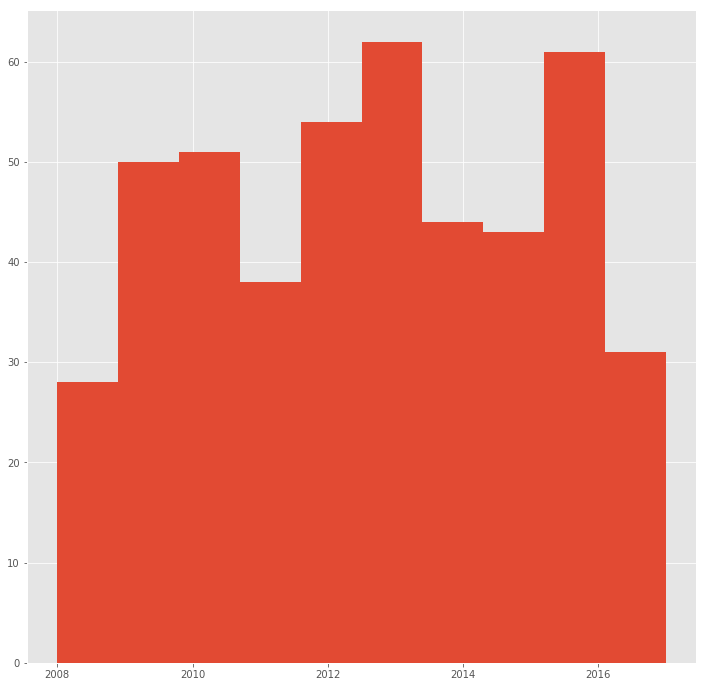

In [101]:
plt.rcParams['figure.figsize']=12,12  # change plot size
plt.hist(date_rows['year'])

([array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0.

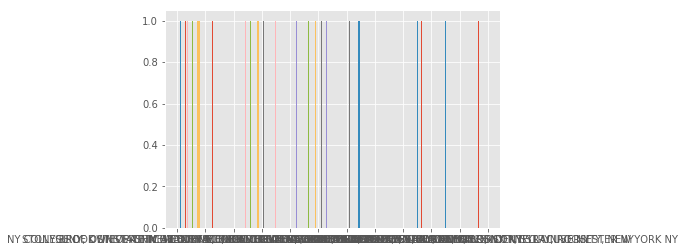

In [24]:
# test=date_rows[date_rows.State=="NY"]
# test=test[['School','Num_Payments']]
# plt.hist(test['School'])

In [35]:
import seaborn as sns

Object `pd.write_csv` not found.


In [36]:
sns.hist(x='year', y='Num_Payments', data=date_rows)

AttributeError: module 'seaborn' has no attribute 'hist'

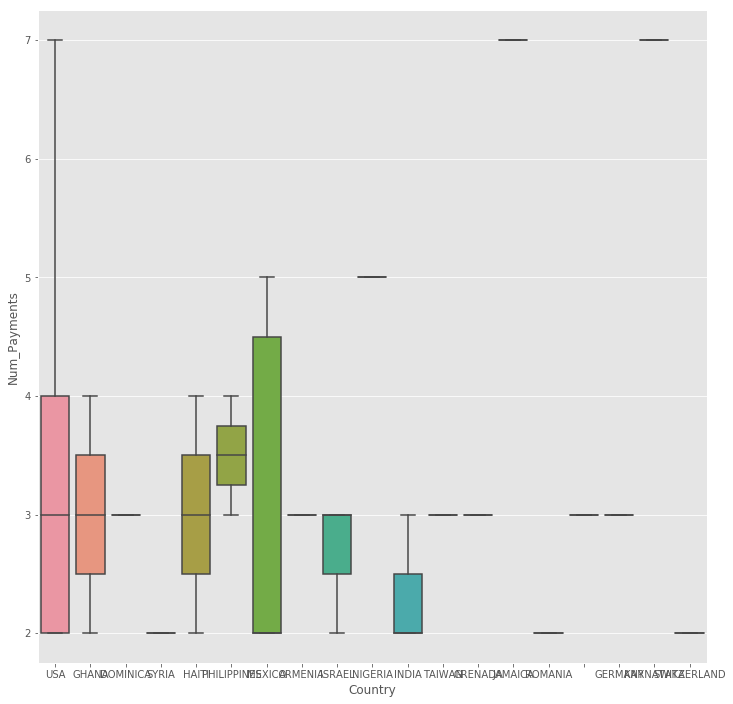

In [93]:
sns.boxplot(x='Country', y='Num_Payments', data=df[df.Num_Payments>1])

In [ ]:
myGrid=sns.FacetGrid(df,col='School',hue='School')
myGrid.map(sns.distplot,'Num_Payments')

ValueError: List of boxplot statistics and `positions` values must have same the length

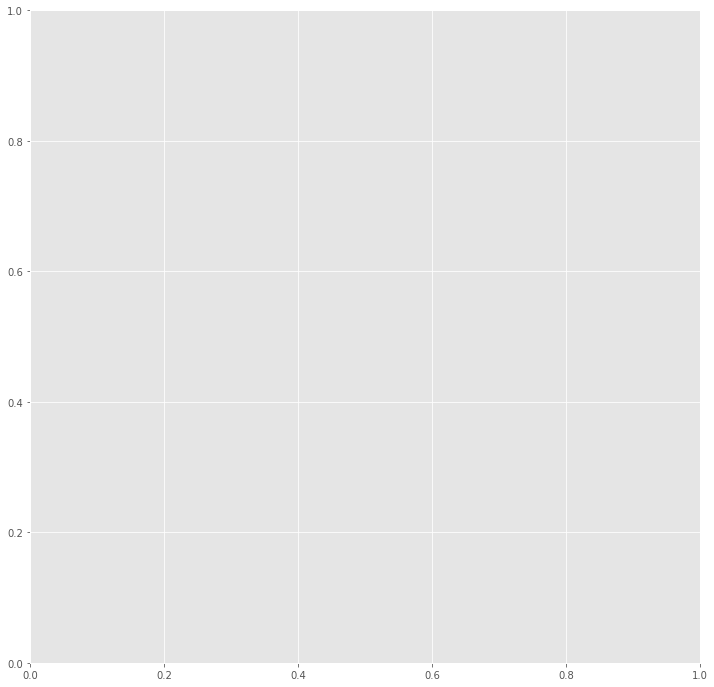

In [95]:
sns.boxplot(x='year', y='Num_Payments', data=date_rows)#[(df.State=="NY")])#& (df.Num_Payments>1)])

In [ ]:
df[df.Num_Payments>6]

In [ ]:
dir(new_df.date)
mal_rows